===================================================
## 4. POD-GAN-deriv
#### DCGAN trained to predict the 3rd-order time derivative $\dddot{a}_n = f(a_n, \dot{a}_n, \ddot{a}_n)$

#### Tianyi Zhao
===================================================

In [1]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`)

<IPython.core.display.Javascript object>

In [2]:
notebookName 

NameError: name 'notebookName' is not defined

In [3]:
notebookName = 'GAN-deriv-3-.ipynb'

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

In [5]:
sys.path.append("..")

# Built package imports
from PredGAN.preprocessing import *
from PredGAN.architectures.generators import *
from PredGAN.architectures.discriminators import *
from PredGAN.train_pred import *

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
tf.random.set_seed(42)
seed(42)

In [7]:
value = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
print ('***If TF can access GPU: ***\n',value) # MUST RETURN True IF IT CAN!!
print('\n')
print("***Num GPUs Available: ***\n", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.set_soft_device_placement(True)

gpus = tf.config.experimental.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
***If TF can access GPU: ***
 True


***Num GPUs Available: ***
 1


## Load data

In [8]:
data_dir = './../data/single_domain/'
pod_coeffs = np.load(data_dir + 'pod_coeffs_1.npy') 
pod_coeffs.shape

(1, 10, 1999)

In [9]:
npod = 5
X_pod = np.transpose(pod_coeffs.reshape(10, 1999)[:npod])
step = 0.25
times = np.arange(0, len(X_pod)*step, step, dtype="float64")

X_pod.shape

(1999, 5)

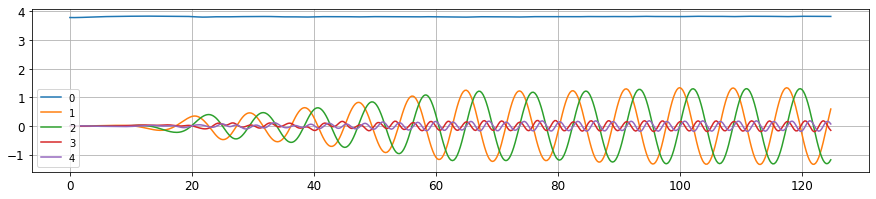

In [10]:
fig, ax = plt.subplots(1,1, figsize=[15,3])
ax.plot(times[0:500], X_pod[0:500]);
ax.grid()
ax.legend(range(5),loc='lower left')

## Prepare data

In [11]:
X_deriv_1 = calculate_deriv(X_pod, step=step)
X_deriv_2 = calculate_deriv(X_deriv_1, step=step)
X_deriv_3 = calculate_deriv(X_deriv_2, step=step)

#a0, (a1-a0)/t, ((a2-a1)-(a1-a0))/t^2, ...
X_train = np.concatenate((X_pod[:-3], X_deriv_1[:-2], X_deriv_2[:-1], X_deriv_3), axis=1)
X_train.shape

(1996, 20)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
np.allclose(X_train, scaler.inverse_transform(X_train_scaled))

True

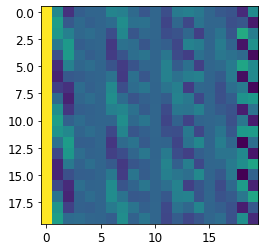

In [13]:
nderiv = 3
ninput = npod*(nderiv+1)

ntimes = 20 # Consecutive times for the GAN
level_step = 4 # step between time levels
nstep = step*level_step

X_pod_concat = concat_timesteps(X_train, ntimes, level_step)
X_pod_concat_flatten = X_pod_concat.reshape(X_pod_concat.shape[0], ntimes*ninput)
plt.imshow(X_pod_concat[500, :, :])

(1916, 20, 20)


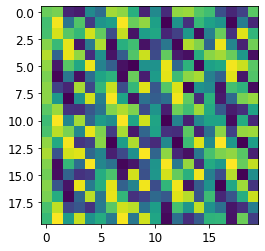

In [14]:
X_train_concat = concat_timesteps(X_train_scaled, ntimes, level_step)
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], ntimes*ninput)

print(X_train_concat.shape)
plt.imshow(X_train_concat[500, :, :])

## Train the GAN

In [15]:
import wandb

# Initialize a new run and set hyperparameters
#wandb.login(key='356a5933239117f23bf9483081f3ca58e5efbe8b')
wandb.init(project='tsp-ai', group='single_domain', entity='tinayzh')
wandb.watch_called = False  # Re-run the model without restarting the runtime, unnecessary after our next release

# config is a variable that holds and saves hyper parameters and inputs
config = wandb.config  # Initialize config

config.datagroup = 'new' #'new_submean'
config.npod = npod
config.ndomain = 1
config.nderiv_order = nderiv
config.ntimes = ntimes # Consecutive times for the GAN
config.ntime_step = level_step # step between time levels

#config.seed = 42  # random seed(default:42)
config.batch_size = 16  # input batch size for training (default:64)
config.latent_space = 100

config.architechture = 'DCGAN'
config.d_dropout = 0.3
config.optimizer = 'Adam'
config.g_lr = 1e-4  # learning rate(default:0.01)
config.d_lr = 1e-4  # learning rate(default:0.01)

config.epochs = 5000  # number of epochs to train(default:10)
#config.no_cuda = False  # disables CUDA training
config.log_interval = 10  # how many batches to wait before logging training status

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tinayzh (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [16]:
BATCH_SIZE = config.batch_size
latent_space = config.latent_space
d_dropout = config.d_dropout
g_lr = config.g_lr
d_lr = config.d_lr
epochs = config.epochs

In [17]:
# Create a tensorflow dataset and split it into batches
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], ntimes, ninput, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_concat))
train_dataset = train_dataset.batch(BATCH_SIZE)
for data in train_dataset:
    print(data)
    break

tf.Tensor(
[[[[6.75087810e-01]
   [9.92986858e-01]
   [5.85039735e-01]
   ...
   [5.34038618e-02]
   [8.49007785e-01]
   [2.47787282e-01]]

  [[7.40624726e-01]
   [8.19376588e-01]
   [8.87259424e-01]
   ...
   [3.15769821e-01]
   [5.51555336e-01]
   [9.91634846e-01]]

  [[8.63902926e-01]
   [4.87293750e-01]
   [9.99624193e-01]
   ...
   [6.42022192e-01]
   [1.13626830e-01]
   [2.36066297e-01]]

  ...

  [[6.85596526e-01]
   [9.85743046e-01]
   [3.81802350e-01]
   ...
   [1.13862706e-02]
   [4.10559922e-01]
   [1.16407946e-01]]

  [[6.89756572e-01]
   [9.45628464e-01]
   [7.29063272e-01]
   ...
   [1.31631687e-01]
   [9.55822885e-01]
   [6.41793728e-01]]

  [[7.96929121e-01]
   [6.88815534e-01]
   [9.64486659e-01]
   ...
   [4.57580835e-01]
   [1.13646194e-01]
   [8.06408286e-01]]]


 [[[7.45489240e-01]
   [7.98797429e-01]
   [9.01759684e-01]
   ...
   [3.43436122e-01]
   [4.72902536e-01]
   [9.85774517e-01]]

  [[8.70759666e-01]
   [4.62215900e-01]
   [9.96593475e-01]
   ...
   [6.6114

In [18]:
generator = make_generator_model_deriv_3()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6400)              640000    
_________________________________________________________________
batch_normalization (BatchNo (None, 6400)              25600     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6400)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 128)         294912    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 128)         0

(1, 20, 20, 1)


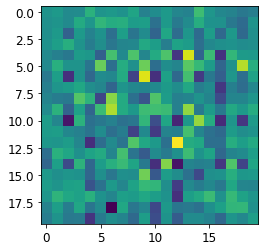

In [19]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0])

In [20]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 64)        640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 10, 10, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)             

In [21]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00284626]], shape=(1, 1), dtype=float32)


In [22]:
gan = keras.models.Sequential([generator, discriminator])

In [23]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [24]:
# The discriminator and the generator optimizers are different since we will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(g_lr)
discriminator_optimizer = tf.keras.optimizers.Adam(d_lr)

In [25]:
# We will reuse this seed overtime 
num_examples_to_generate = 5
seed = tf.random.normal([num_examples_to_generate, latent_space])

In [26]:
# logs to follow losses on tensorboard
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
generator_log_dir = './logs/' + notebookName[:-6] + '/generator'
discriminator_log_dir = './logs/' + notebookName[:-6] + '/discriminator'

generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
discriminator_summary_writer = tf.summary.create_file_writer(discriminator_log_dir)

In [27]:
with tf.device("/gpu:0"):
    hist = train(train_dataset, epochs, BATCH_SIZE, latent_space, generator_mean_loss, \
         discriminator_mean_loss, generator_optimizer, discriminator_optimizer, \
         generator_summary_writer, discriminator_summary_writer, \
         generator, discriminator, gan, notebookName)

Epoch 1/5000
discriminator loss: 1.184732 - generator loss: 0.680910 - 3s
Epoch 2/5000
discriminator loss: 1.273976 - generator loss: 0.810103 - 1s
Epoch 3/5000
discriminator loss: 1.134435 - generator loss: 1.337697 - 1s
Epoch 4/5000
discriminator loss: 1.004526 - generator loss: 1.156849 - 1s
Epoch 5/5000
discriminator loss: 0.823116 - generator loss: 1.367010 - 1s
Epoch 6/5000


KeyboardInterrupt: 

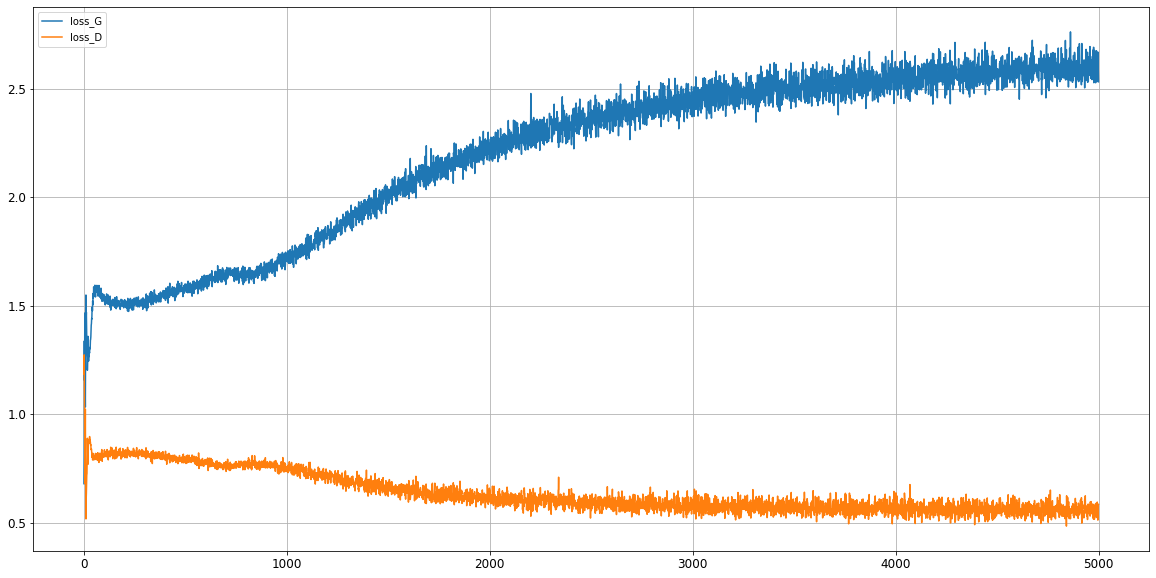

In [47]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(hist)
ax.legend(['loss_G', 'loss_D'])
#ax.set_yscale('log')
ax.grid()

In [49]:
import joblib
joblib.dump(scaler, "models/scaler-gan-deriv-3.pkl")
gan.save("models/gan-deriv-3.h5")

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

noise = tf.random.normal(shape=[1, latent_space])
X_generated = scaler.inverse_transform(gan.layers[0].predict(noise).reshape(ntimes, ninput))

In [ ]:
plt.imshow(X_generated)
plt.colorbar()

In [52]:
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0

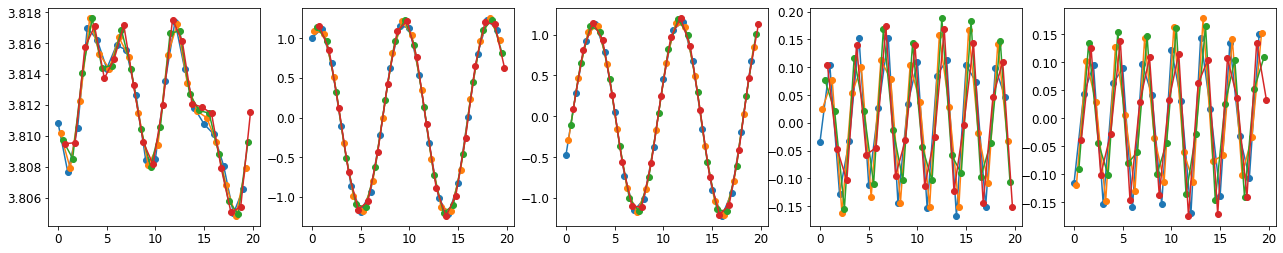

In [53]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,ntimes*nstep,nstep), X_0[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step,ntimes*nstep+step,nstep), X_1[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*2,ntimes*nstep+step*2,nstep), X_2[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*3,ntimes*nstep+step*3,nstep), X_3[:,i], '-o')

## Predict with the GAN

### Predict one point

**In this section we data assimilated the first 8 points generated by the GAN and predict the 9th**

**We use the singular values as weights for the optimization**

In [28]:
df = pd.read_table(data_dir + 'singular_values_1.dat', sep = ',', header=None, engine='python', comment = '#')
 
df.columns = (['index', 's_values', 'normalised s_values', 'cumulative energy'])
df.head()

,index,s_values,normalised s_values,cumulative energy
0,0,170.97800,1.000000,0.892148
1,1,40.37620,0.236149,0.941899
2,2,39.52840,0.231190,0.989584
3,3,5.39844,0.031574,0.990473
4,4,5.28227,0.030894,0.991325


In [29]:
#weight = tf.constant(pca_compress.singular_values_, dtype=tf.float32)
values = df.values[:, 1].astype(np.float32)
weight = values[:ninput]
weight

array([170.978  ,  40.3762 ,  39.5284 ,   5.39844,   5.28227,   5.09296,
         4.98075,   4.80741,   4.5183 ,   4.44503,   4.39604,   3.81641,
         3.52731,   3.47671,   3.11096,   2.97483,   2.78567,   2.65468,
         2.54914,   2.32886], dtype=float32)

In [30]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(5e-2)

Loss:  0.0030920787
<tf.Variable 'Variable:0' shape=(1, 100) dtype=float32, numpy=
array([[ 4.5058052e-03, -1.9656919e+00,  1.1235625e+00, -2.6586847e+00,
        -2.2570472e+00, -4.8632431e-01,  1.0395173e+00, -9.2505664e-02,
         2.0894802e+00,  3.6394840e-01, -1.1382012e+00, -9.0669191e-01,
        -2.6884637e+00, -4.8770753e-01, -2.6344557e+00,  2.1380489e+00,
        -6.7226452e-01, -3.0953259e+00, -1.8596831e-01,  1.7333307e+00,
        -4.0439159e-01, -1.3973790e+00, -1.8819911e+00, -1.1074767e+00,
        -8.7649226e-01,  8.9426100e-01,  8.8995749e-01,  2.7589878e-01,
        -8.9717609e-01, -3.4678276e+00, -3.0811286e-02,  5.4219389e-01,
        -5.9991914e-01, -1.3194672e+00,  1.5863680e+00, -3.2874697e-01,
        -2.9964575e-03, -2.0593388e+00, -2.2767987e+00, -9.1904998e-02,
        -9.5319605e-01, -1.0770571e+00, -6.4809872e-03,  4.9653296e+00,
        -9.2840445e-01, -1.0190088e+00, -2.6893133e-01,  1.7333714e+00,
        -4.3006161e-01, -1.8883342e+00, -2.5339100e-0

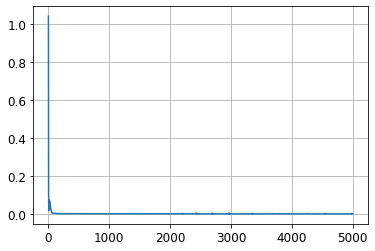

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

n = 500
real_coding = X_train_concat_flatten[n].reshape(1,-1)
real_coding = real_coding[:,:ninput*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = optimize_coding(real_coding, weight, latent_space, \
             mse, generator, optimizer, ntimes, ninput)
print('Loss: ', mse_loss(mse, generator(latent_values)[:,:(ntimes - 1),:,:], real_coding, \
                         weight, ninput).numpy())
print(latent_values)

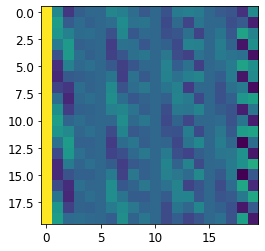

In [33]:
X_generated = scaler.inverse_transform(generator.predict(
    tf.convert_to_tensor(latent_values)).reshape(ntimes,ninput))
plt.imshow(X_generated)

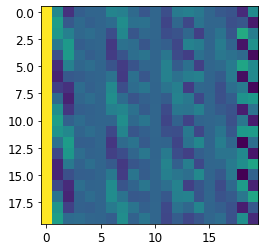

In [34]:
X_real = scaler.inverse_transform(X_train_concat_flatten[n].reshape(ntimes,ninput))
plt.imshow(X_real)

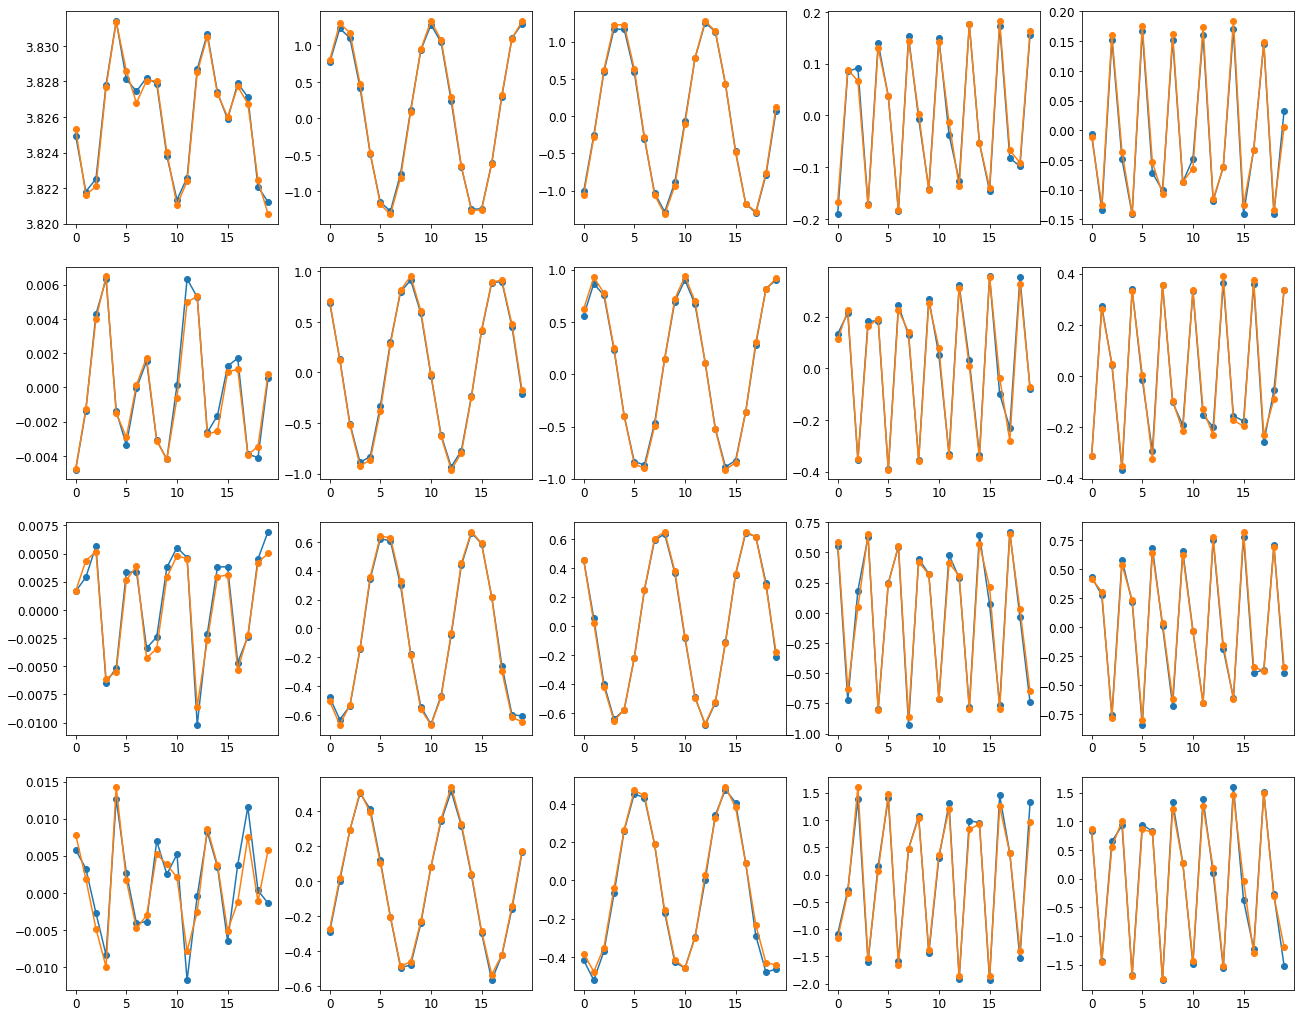

In [35]:
fig, ax = plt.subplots(4, 5, figsize=[22, 18])
for i in range(5):
    ax.flatten()[i].plot(X_generated[:,i], '-o')
    ax.flatten()[i].plot(X_real[:,i],'-o')

    ax.flatten()[i+5].plot(X_generated[:,i+5], '-o')
    ax.flatten()[i+5].plot(X_real[:,i+5],'-o')

    ax.flatten()[i+10].plot(X_generated[:,i+10], '-o')
    ax.flatten()[i+10].plot(X_real[:,i+10],'-o')
    
    ax.flatten()[i+15].plot(X_generated[:,i+15], '-o')
    ax.flatten()[i+15].plot(X_real[:,i+15],'-o')

**The figure below shows the difference between the predicted and real data**

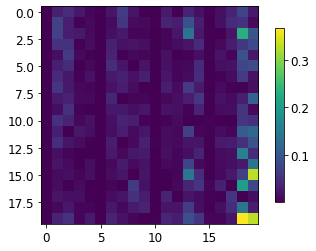

In [36]:
error = X_generated-X_real
plt.imshow(abs(error))
plt.colorbar(shrink=0.8)

**The figure below shows the first 8 points after the data assimilation and the 9th point as a prediction compared with real data**

In [37]:
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0

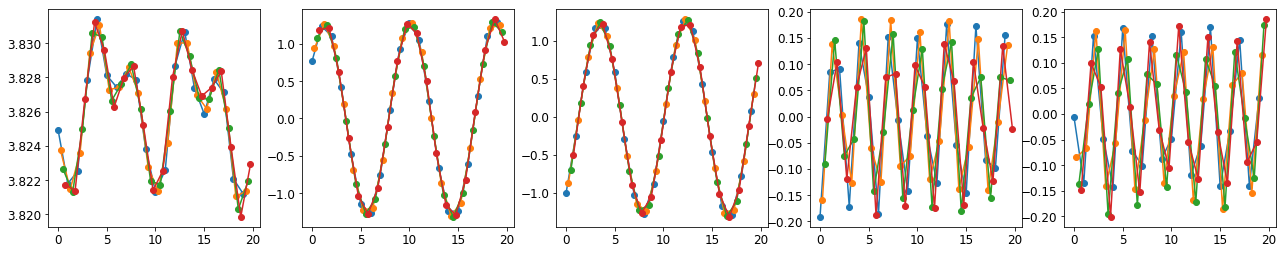

In [38]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,ntimes*nstep,nstep), X_0[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step,ntimes*nstep+step,nstep), X_1[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*2,ntimes*nstep+step*2,nstep), X_2[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*3,ntimes*nstep+step*3,nstep), X_3[:,i], '-o')

## Predict multiple points
In this section we predict multiple points. We use the last predictions as the points to data assimilate in the next prediction.

### Start point = time step 500

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

n = 500
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:ninput*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

tf.config.run_functions_eagerly(True)
latent_values = optimize_coding_multi(latent_values, real_coding, weight, epochs, \
                                      mse, generator, optimizer, ntimes, ninput)
X_predict = list(generator(latent_values).numpy().reshape(-1,ninput))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ninput:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(20): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding_multi(latent_values, real_coding, weight, epochs, \
                                          mse, generator, optimizer, ntimes, ninput)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    print('=====%d====='%i)
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ninput:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)
X_generated = scaler.inverse_transform(X_predict)

=====0=====
=====1=====
=====2=====
=====3=====
=====4=====
=====5=====
=====6=====
=====7=====
=====8=====
=====9=====
=====10=====
=====11=====
=====12=====
=====13=====
=====14=====
=====15=====
=====16=====
=====17=====
=====18=====
=====19=====


In [44]:
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0

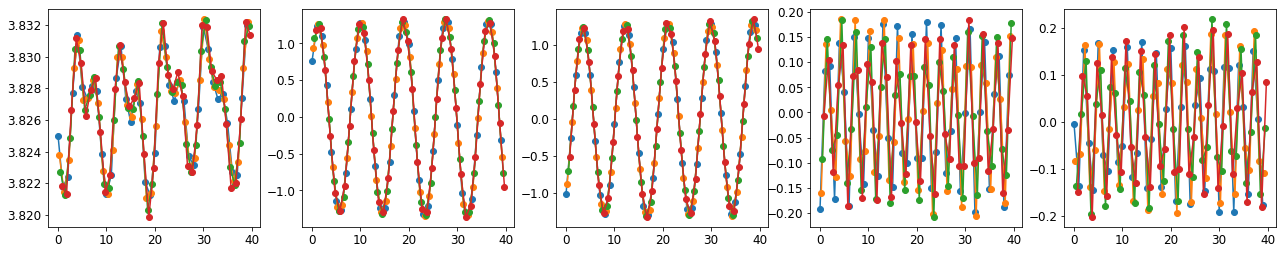

In [45]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,40,step*4), X_0[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step,40+step,step*4), X_1[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*2,40+step*2,step*4), X_2[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*3,40+step*3,step*4), X_3[:,i], '-o')

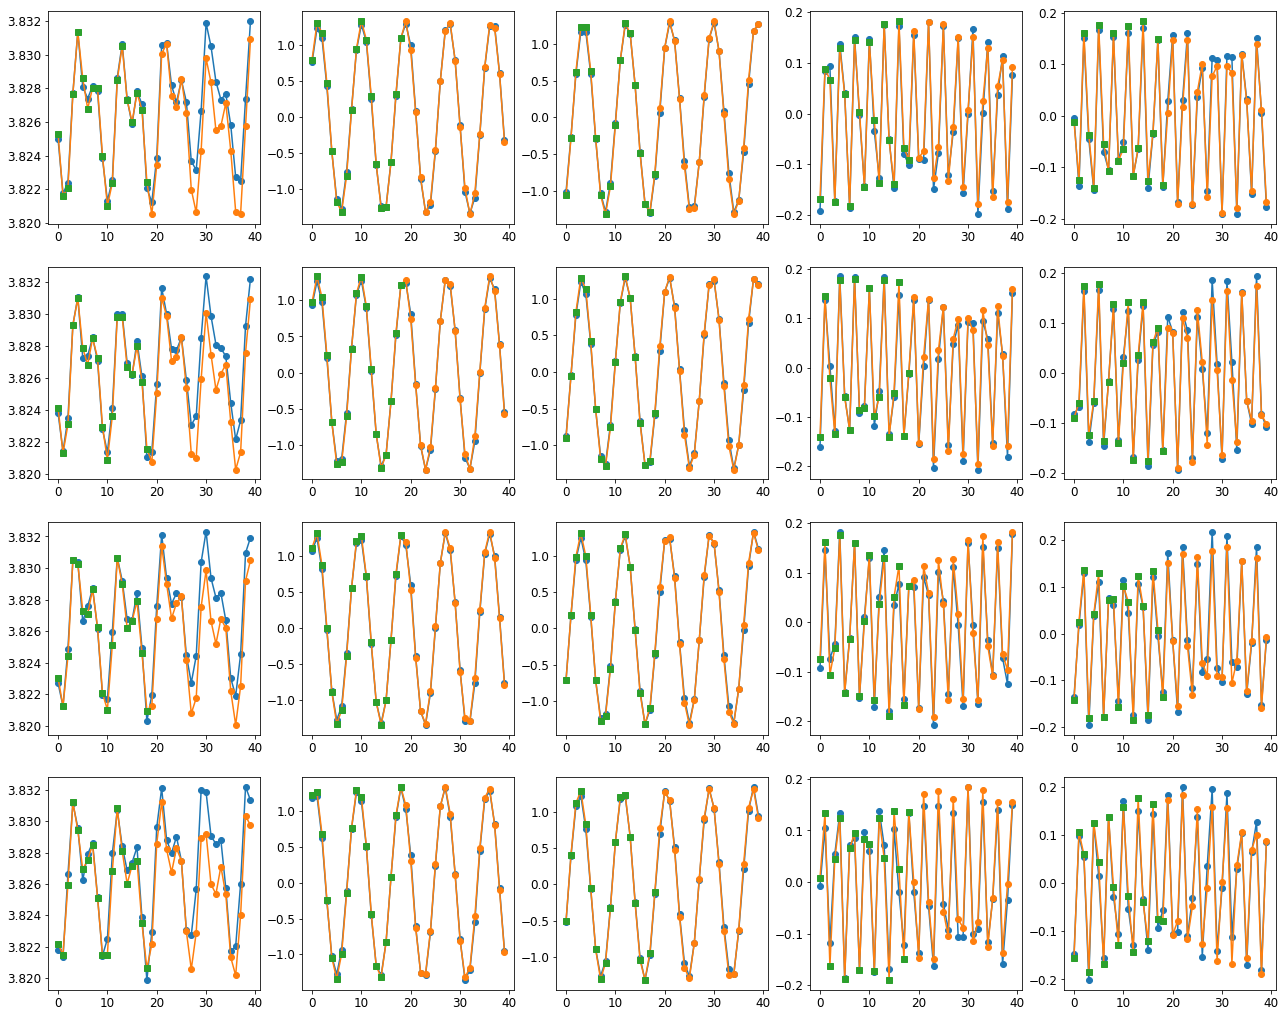

In [46]:
fig, ax = plt.subplots(4, 5, figsize=[22, 18])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,40,step*4), X_0[:,i], '-o')
    ax.flatten()[i].plot(np.arange(0,40,step*4),X_pod[500:660:4,i],'-o')
    ax.flatten()[i].plot(np.arange(0,19,step*4),X_pod[500:576:4,i],'s')
    
    ax.flatten()[i+5].plot(np.arange(0,40,step*4), X_1[:,i], '-o')
    ax.flatten()[i+5].plot(np.arange(0,40,step*4), X_pod[501:661:4,i],'-o')
    ax.flatten()[i+5].plot(np.arange(0,19,step*4), X_pod[501:577:4,i],'s')

    ax.flatten()[i+10].plot(np.arange(0,40,step*4), X_2[:,i], '-o')
    ax.flatten()[i+10].plot(np.arange(0,40,step*4), X_pod[502:662:4,i],'-o')
    ax.flatten()[i+10].plot(np.arange(0,19,step*4), X_pod[502:578:4,i],'s')
    
    ax.flatten()[i+15].plot(np.arange(0,40,step*4), X_3[:,i], '-o')
    ax.flatten()[i+15].plot(np.arange(0,40,step*4), X_pod[503:663:4,i],'-o')
    ax.flatten()[i+15].plot(np.arange(0,19,step*4), X_pod[503:579:4,i],'s')

### Start point = time step 1000

In [101]:
np.random.seed(42)
tf.random.set_seed(42)

n = 1000
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:ninput*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

tf.config.run_functions_eagerly(True)
latent_values = optimize_coding_multi(latent_values, real_coding, weight, epochs, \
                                      mse, generator, optimizer, ntimes, ninput)
X_predict = list(generator(latent_values).numpy().reshape(-1,ninput))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ninput:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(20): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding_multi(latent_values, real_coding, weight, epochs, \
                                          mse, generator, optimizer, ntimes, ninput)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    print('=====%d====='%i)
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ninput:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)
X_generated = scaler.inverse_transform(X_predict)

=====0=====
=====1=====
=====2=====
=====3=====
=====4=====
=====5=====
=====6=====
=====7=====
=====8=====
=====9=====
=====10=====
=====11=====
=====12=====
=====13=====
=====14=====
=====15=====
=====16=====
=====17=====
=====18=====
=====19=====


In [102]:
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0

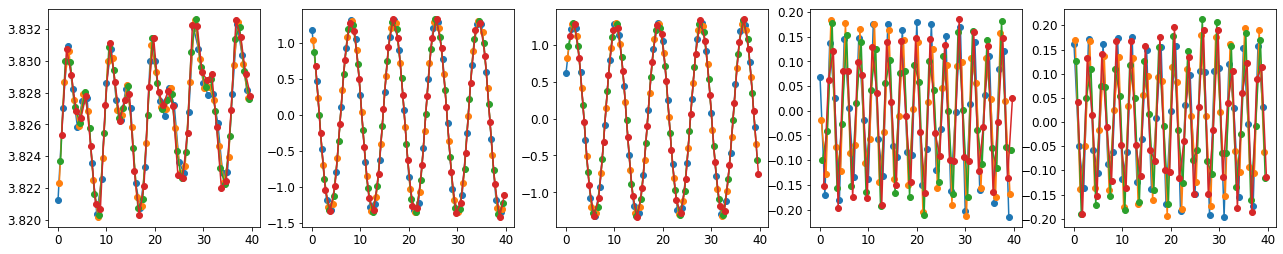

In [103]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,40,step*4), X_0[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step,40+step,step*4), X_1[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*2,40+step*2,step*4), X_2[:,i], '-o')
    ax.flatten()[i].plot(np.arange(step*3,40+step*3,step*4), X_3[:,i], '-o')

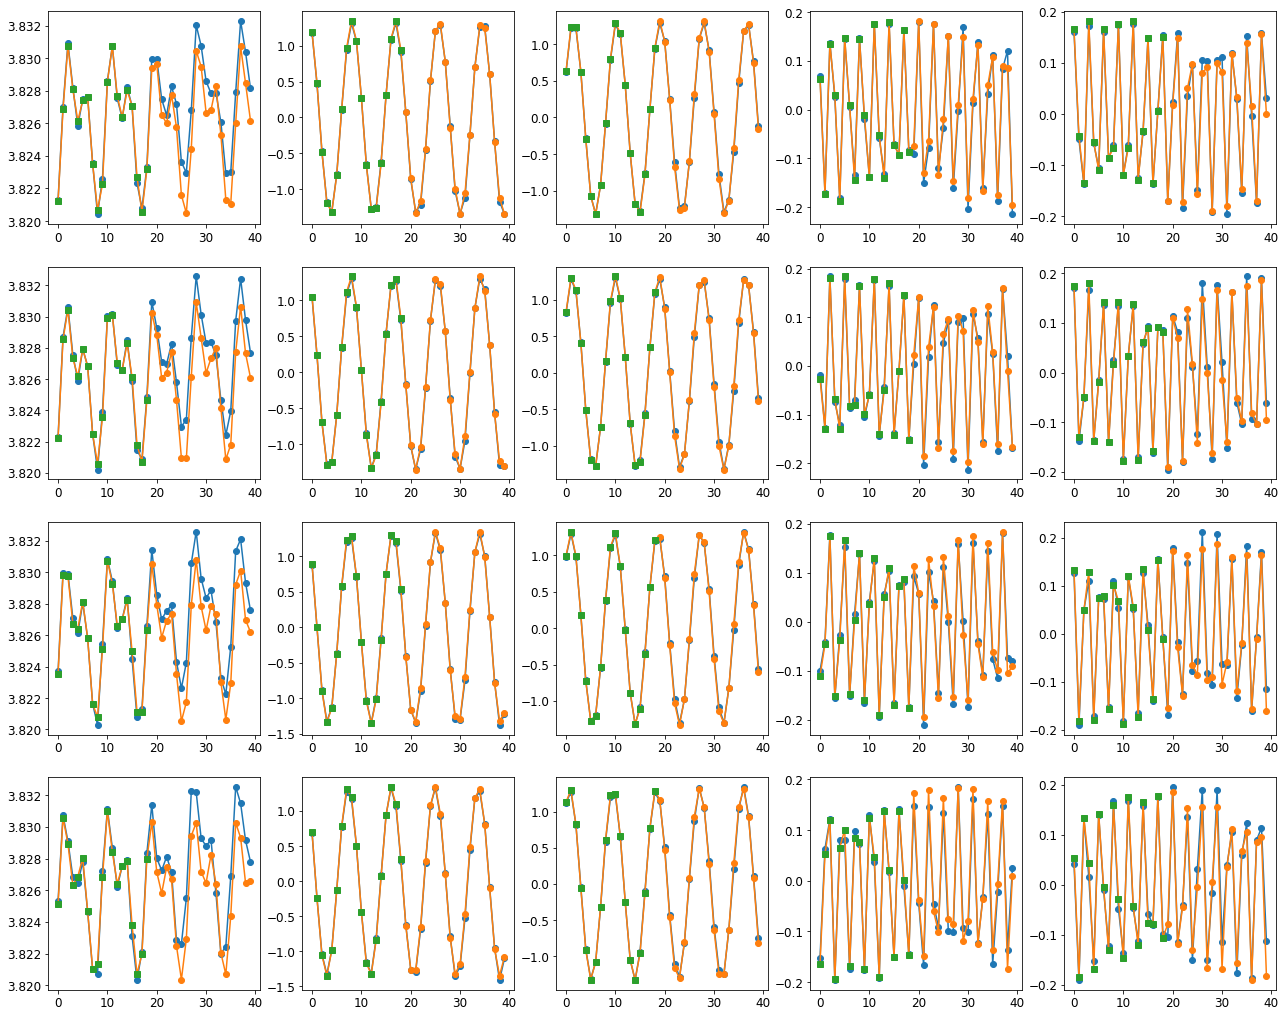

In [104]:
fig, ax = plt.subplots(4, 5, figsize=[22, 18])
for i in range(5):
    ax.flatten()[i].plot(np.arange(0,40,step*4), X_0[:,i], '-o')
    ax.flatten()[i].plot(np.arange(0,40,step*4),X_pod[1000:1160:4,i],'-o')
    ax.flatten()[i].plot(np.arange(0,19,step*4),X_pod[1000:1076:4,i],'s')
    
    ax.flatten()[i+5].plot(np.arange(0,40,step*4), X_1[:,i], '-o')
    ax.flatten()[i+5].plot(np.arange(0,40,step*4), X_pod[1001:1161:4,i],'-o')
    ax.flatten()[i+5].plot(np.arange(0,19,step*4), X_pod[1001:1077:4,i],'s')

    ax.flatten()[i+10].plot(np.arange(0,40,step*4), X_2[:,i], '-o')
    ax.flatten()[i+10].plot(np.arange(0,40,step*4), X_pod[1002:1162:4,i],'-o')
    ax.flatten()[i+10].plot(np.arange(0,19,step*4), X_pod[1002:1078:4,i],'s')
    
    ax.flatten()[i+15].plot(np.arange(0,40,step*4), X_3[:,i], '-o')
    ax.flatten()[i+15].plot(np.arange(0,40,step*4), X_pod[1003:1163:4,i],'-o')
    ax.flatten()[i+15].plot(np.arange(0,19,step*4), X_pod[1003:1079:4,i],'s')

## Predict the whole simulation

### Start point = time step 100

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

n = 100
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:ninput*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

tf.config.run_functions_eagerly(True)
latent_values = optimize_coding_multi(latent_values, real_coding, weight, epochs, \
                                      mse, generator, optimizer, ntimes, ninput)
X_predict = list(generator(latent_values).numpy().reshape(-1,ninput))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ninput:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(200): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding_multi(latent_values, real_coding, weight, epochs, \
                                          mse, generator, optimizer, ntimes, ninput)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    print('=====%d====='%i)
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ninput:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

=====0=====
=====1=====
=====2=====
=====3=====
=====4=====
=====5=====
=====6=====
=====7=====
=====8=====
=====9=====
=====10=====
=====11=====
=====12=====
=====13=====
=====14=====
=====15=====
=====16=====
=====17=====
=====18=====
=====19=====
=====20=====
=====21=====
=====22=====
=====23=====
=====24=====
=====25=====
=====26=====
=====27=====
=====28=====
=====29=====
=====30=====
=====31=====
=====32=====
=====33=====
=====34=====
=====35=====
=====36=====
=====37=====
=====38=====
=====39=====
=====40=====
=====41=====
=====42=====
=====43=====
=====44=====
=====45=====
=====46=====
=====47=====
=====48=====
=====49=====
=====50=====
=====51=====
=====52=====
=====53=====
=====54=====
=====55=====
=====56=====
=====57=====
=====58=====
=====59=====
=====60=====
=====61=====
=====62=====
=====63=====
=====64=====
=====65=====
=====66=====
=====67=====
=====68=====
=====69=====
=====70=====
=====71=====
=====72=====
=====73=====
=====74=====
=====75=====
=====76=====
=====77==

In [61]:
X_generated = scaler.inverse_transform(X_predict)
np.save('X_deriv_100.npy',X_generated)

In [86]:
X0_0 = X_pod[100:980:4]
X0_1 = X_pod[101:981:4]
X0_2 = X_pod[102:982:4]
X0_3 = X_pod[103:983:4]
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0

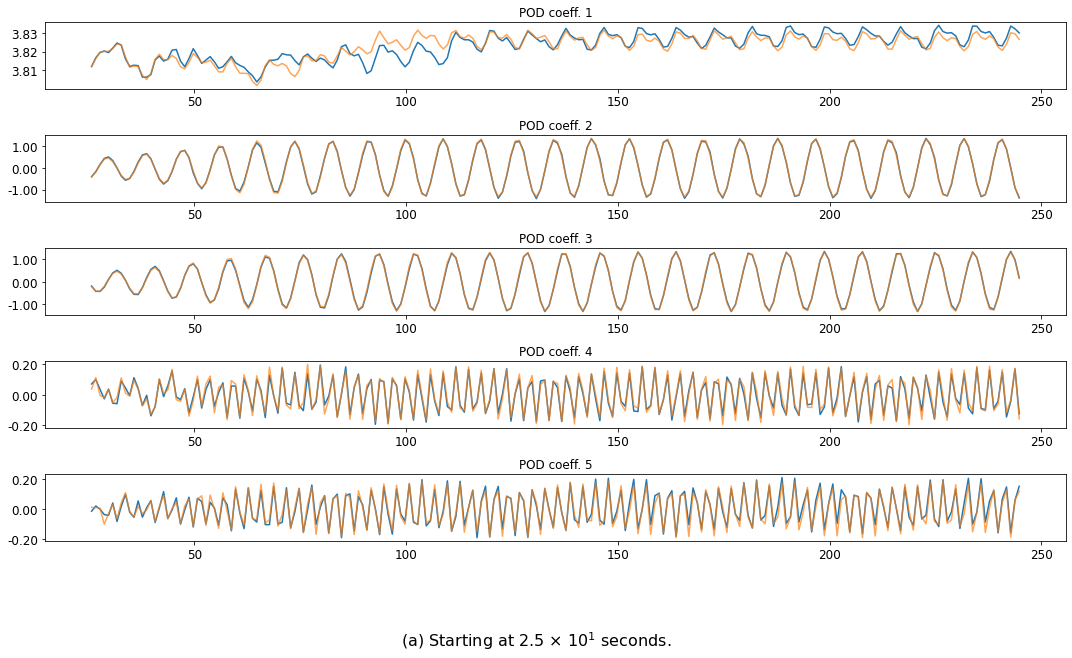

In [63]:
fig, ax = plt.subplots(5,1, figsize=[15,8])
for i in range(5):
    ax.flatten()[i].set_title("POD coeff. %d"%(i+1))
    ax.flatten()[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.flatten()[i].plot(times[103:983:4], X_3[:,i])
    ax.flatten()[i].plot(times[103:983:4], X0_3[:,i], alpha=0.7)
plt.tight_layout()
my_suptitle = plt.suptitle("(a) Starting at 2.5 × $10^1$ seconds.", y=-0.1, fontsize=16)
plt.savefig('images/GAN_deriv_100.png', dpi=300, bbox_inches='tight',bbox_extra_artists=[my_suptitle]) 

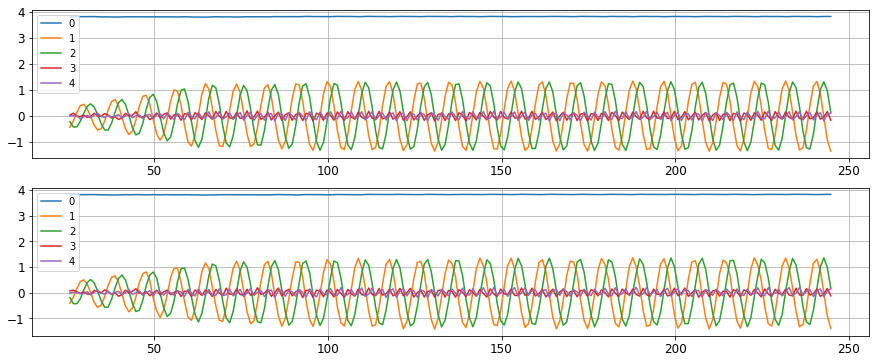

In [64]:
fig, ax = plt.subplots(2,1, figsize=[15,6])
ax[0].plot(times[103:983:4], X0_3);
ax[0].grid()
ax[0].legend(range(5))

ax[1].plot(times[103:983:4], X_3);
ax[1].grid()
ax[1].legend(range(5))

Output as `csv`

In [91]:
X_concat = []
for i in range(ntimes+200):
    X_concat.append(X_0[i,:])
    X_concat.append(X_1[i,:])
    X_concat.append(X_2[i,:])
    X_concat.append(X_3[i,:])
X_concat = np.array(X_concat)

In [94]:
out_dir = './../data/outputs/'
pod_coeffs_gen = np.transpose(X_concat)
np.savetxt(out_dir+'gan_deriv_100.csv', pod_coeffs_gen , delimiter=',')

# generate reconstructed pod coeffs
pod_basis = np.load(data_dir+'pod_basis_1.npy')
reconstructed = np.reshape((pod_basis[:,:5] @ pod_coeffs_gen), [1, 2, 221, 42, -1])

np.save(out_dir+'gan_deriv_100.npy', reconstructed)

Calculate error and relative error

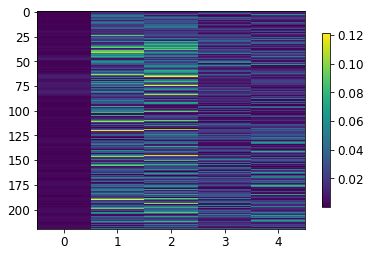

In [65]:
X_true = X0_3
X_pred = X_3
error = X_pred-X_true
relative_error = error/X_true
plt.imshow(abs(error), aspect='auto', interpolation='None')
plt.colorbar(shrink=0.8)

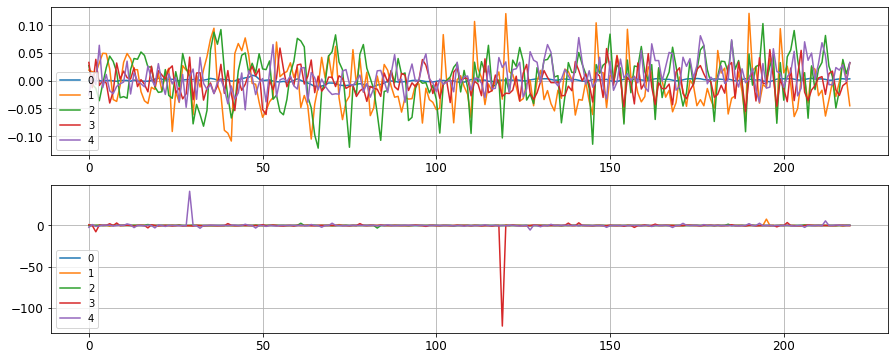

In [68]:
fig, ax = plt.subplots(2,1, figsize=[15,6])
ax[0].plot(error);
ax[0].grid()
ax[0].legend(range(5),loc='lower left')

ax[1].plot(relative_error);
ax[1].grid()
ax[1].legend(range(5),loc='lower left')

Calculate prediction RMSE

In [66]:
# calculate RMSE
pred_mse = np.mean(tf.keras.losses.MSE(X_true, X_pred))
pred_rmse = np.sqrt(pred_mse)
config.prediction_rmse_100 = pred_rmse
print('Prediction RMSE: %.4f' % pred_rmse)

Prediction RMSE: 0.0314


### Start point = time step 1000

In [73]:
np.random.seed(42)
tf.random.set_seed(42)

n = 1000
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:ninput*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

tf.config.run_functions_eagerly(True)
latent_values = optimize_coding_multi(latent_values, real_coding, weight, epochs, \
                                      mse, generator, optimizer, ntimes, ninput)
X_predict = list(generator(latent_values).numpy().reshape(-1,ninput))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ninput:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(200): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding_multi(latent_values, real_coding, weight, epochs, \
                                          mse, generator, optimizer, ntimes, ninput)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    print('=====%d====='%i)
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ninput:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

=====0=====
=====1=====
=====2=====
=====3=====
=====4=====
=====5=====
=====6=====
=====7=====
=====8=====
=====9=====
=====10=====
=====11=====
=====12=====
=====13=====
=====14=====
=====15=====
=====16=====
=====17=====
=====18=====
=====19=====
=====20=====
=====21=====
=====22=====
=====23=====
=====24=====
=====25=====
=====26=====
=====27=====
=====28=====
=====29=====
=====30=====
=====31=====
=====32=====
=====33=====
=====34=====
=====35=====
=====36=====
=====37=====
=====38=====
=====39=====
=====40=====
=====41=====
=====42=====
=====43=====
=====44=====
=====45=====
=====46=====
=====47=====
=====48=====
=====49=====
=====50=====
=====51=====
=====52=====
=====53=====
=====54=====
=====55=====
=====56=====
=====57=====
=====58=====
=====59=====
=====60=====
=====61=====
=====62=====
=====63=====
=====64=====
=====65=====
=====66=====
=====67=====
=====68=====
=====69=====
=====70=====
=====71=====
=====72=====
=====73=====
=====74=====
=====75=====
=====76=====
=====77==

In [74]:
X_generated = scaler.inverse_transform(X_predict)
np.save('X_deriv_1000.npy', X_generated)

In [96]:
X0_0 = X_pod[1000:1880:4]
X0_1 = X_pod[1001:1881:4]
X0_2 = X_pod[1002:1882:4]
X0_3 = X_pod[1003:1883:4]
# Calculate the predicted value of the next time step
# a_n
X_0 = X_generated[:, :5]
# a_n+1
X_1 = step * X_generated[:, 5:10] + X_0
# a_n+2
X_2 = step**2 * X_generated[:, 10:15] + 2*X_1 - X_0
# a_n+3
X_3 = step**3 * X_generated[:, 15:20] + 3*X_2 - 3*X_1 + X_0

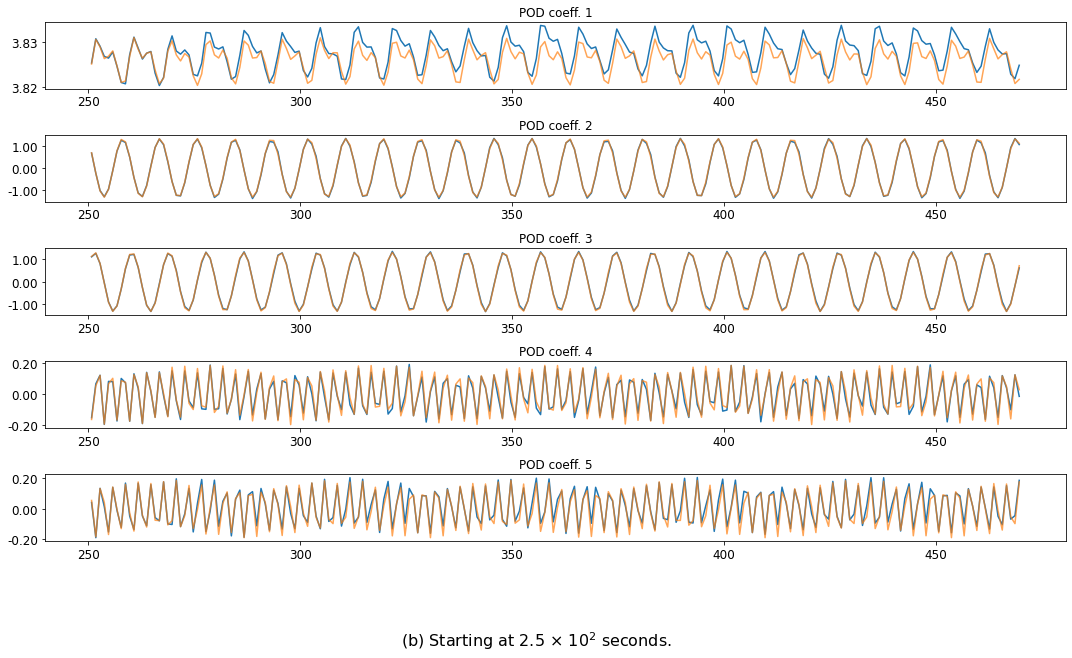

In [77]:
fig, ax = plt.subplots(5,1, figsize=[15,8])
for i in range(5):
    ax.flatten()[i].set_title("POD coeff. %d"%(i+1))
    ax.flatten()[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.flatten()[i].plot(times[1003:1883:4], X_3[:,i])
    ax.flatten()[i].plot(times[1003:1883:4], X0_3[:,i], alpha=0.7)
plt.tight_layout()
my_suptitle = plt.suptitle("(b) Starting at 2.5 × $10^2$ seconds.", y=-0.1, fontsize=16)
plt.savefig('images/GAN_deriv_1000.png', dpi=300, bbox_inches='tight',bbox_extra_artists=[my_suptitle]) 

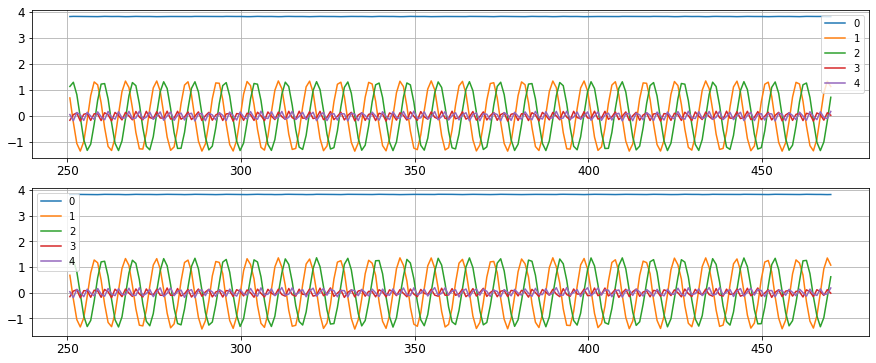

In [78]:
fig, ax = plt.subplots(2,1, figsize=[15,6])
ax[0].plot(times[1003:1883:4], X0_3);
ax[0].grid()
ax[0].legend(range(5))

ax[1].plot(times[1003:1883:4], X_3);
ax[1].grid()
ax[1].legend(range(5))

Output as `csv`

In [98]:
X_concat = []
for i in range(ntimes+200):
    X_concat.append(X_0[i,:])
    X_concat.append(X_1[i,:])
    X_concat.append(X_2[i,:])
    X_concat.append(X_3[i,:])
X_concat = np.array(X_concat)

In [99]:
out_dir = './../data/outputs/'
pod_coeffs_gen = np.transpose(X_concat)
np.savetxt(out_dir+'gan_deriv_1000.csv', pod_coeffs_gen , delimiter=',')

# generate reconstructed pod coeffs
pod_basis = np.load(data_dir+'pod_basis_1.npy')
reconstructed = np.reshape((pod_basis[:,:5] @ pod_coeffs_gen), [1, 2, 221, 42, -1])

np.save(out_dir+'gan_deriv_1000.npy', reconstructed)

Calculate error and relative error

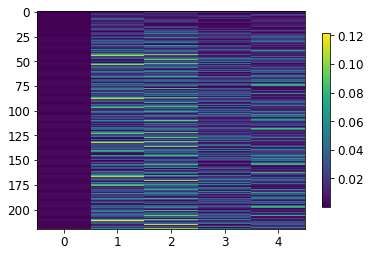

In [80]:
X_true = X0_3
X_pred = X_3
error = X_pred-X_true
relative_error = error/X_true
plt.imshow(abs(error), aspect='auto', interpolation='None')
plt.colorbar(shrink=0.8)

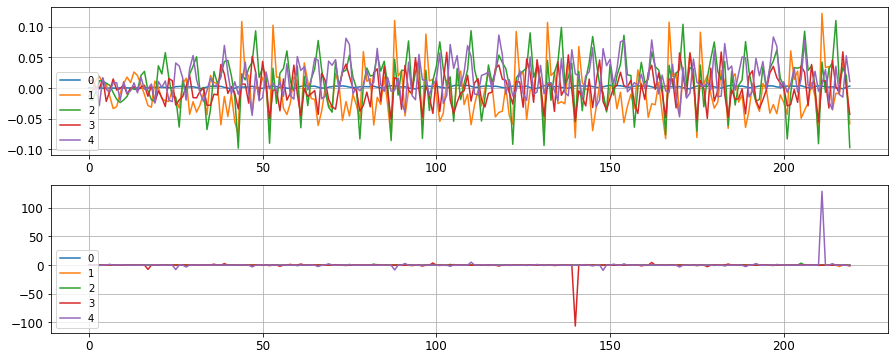

In [81]:
fig, ax = plt.subplots(2,1, figsize=[15,6])
ax[0].plot(error);
ax[0].grid()
ax[0].legend(range(5),loc='lower left')

ax[1].plot(relative_error);
ax[1].grid()
ax[1].legend(range(5),loc='lower left')

Calculate prediction RMSE

In [83]:
# calculate RMSE
pred_mse = np.mean(tf.keras.losses.MSE(X_true, X_pred))
pred_rmse = np.sqrt(pred_mse)
config.prediction_rmse_1000 = pred_rmse
print('Prediction RMSE: %.4f' % pred_rmse)

Prediction RMSE: 0.0311
